<a href="https://colab.research.google.com/github/BhushanPawar-01/Itrusion_Detection_System_using_CNN/blob/main/NSL_KDD_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



---



---


**Importing Libraries and Dataset**

In [4]:
#importing libraries

import numpy as np
import pandas as pd
from joblib import dump, load
import sklearn
import sklearn.preprocessing
from sklearn import metrics
from scipy.stats import zscore
from sklearn.metrics import accuracy_score, f1_score, precision_score,recall_score

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Embedding, Flatten
from keras.layers import LSTM, SimpleRNN, GRU, Bidirectional, BatchNormalization,Convolution1D,MaxPooling1D, Reshape, GlobalAveragePooling1D 
from utilities import SequentialModel
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split


/tmp/ipykernel_24853/4220499764.py:4: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
2024-02-14 18:33:04.926861: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-02-14 18:33:04.960027: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-14 18:33:04.960065: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin

In [5]:
#Loading training set into dataframe
df_train = pd.read_csv('train.csv')
df_train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate   labels  
0                      0.00   normal  
1                      0.00   normal  
2                      0.00  neptune  
3                      0.01   normal  
4                      0.00   normal  

[5 rows x 42 columns]

In [6]:
df_test = pd.read_csv('test.csv')
df_test.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         5           tcp      smtp    SF       2429        475     0   
1         0           udp  domain_u    SF         45        134     0   
2         0           udp  domain_u    SF         45         80     0   
3      1979           udp     other    SF        145        105     0   
4     14462           tcp     other  RSTR          1          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  57   
1               0       0    0  ...                 155   
2               0       0    0  ...                 255   
3               0       0    0  ...                   2   
4               0       0    0  ...                   2   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.11                    0.02   
1                    0.80                    0.02   
2                    1.00                    0.00   
3                    0.01                    0.84   
4                    0.01                    0.68   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.01                         0.04   
1                         0.01                         0.00   
2                         0.01                         0.00   
3                         1.00                         0.00   
4                         1.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  0.87   
1                   0.0                       0.0                  0.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  1.00   

   dst_host_srv_rerror_rate     labels  
0                       0.0     normal  
1                       0.0     normal  
2                       0.0     normal  
3                       0.0     normal  
4                       1.0  portsweep  

[5 rows x 42 columns]



---



---



## **Data Preprocessing**

In [7]:
#Reset column names for training set
df_train.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass']
df_train.head()

duration protocol_type   service flag  src_bytes  dst_bytes  land  \
0         0           tcp  ftp_data   SF        491          0     0   
1         0           udp     other   SF        146          0     0   
2         0           tcp   private   S0          0          0     0   
3         0           tcp      http   SF        232       8153     0   
4         0           tcp      http   SF        199        420     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  25   
1               0       0    0  ...                   1   
2               0       0    0  ...                  26   
3               0       0    0  ...                 255   
4               0       0    0  ...                 255   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.17                    0.03   
1                    0.00                    0.60   
2                    0.10                    0.05   
3                    1.00                    0.00   
4                    1.00                    0.00   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.17                         0.00   
1                         0.88                         0.00   
2                         0.00                         0.00   
3                         0.03                         0.04   
4                         0.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                  0.00                      0.00                  0.05   
1                  0.00                      0.00                  0.00   
2                  1.00                      1.00                  0.00   
3                  0.03                      0.01                  0.00   
4                  0.00                      0.00                  0.00   

   dst_host_srv_rerror_rate  subclass  
0                      0.00    normal  
1                      0.00    normal  
2                      0.00   neptune  
3                      0.01    normal  
4                      0.00    normal  

[5 rows x 42 columns]

In [8]:
#Reset column names for testing set
df_test.columns = ['duration', 'protocol_type', 'service', 'flag', 'src_bytes',
'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot',
'num_failed_logins', 'logged_in', 'num_compromised', 'root_shell',
'su_attempted', 'num_root', 'num_file_creations', 'num_shells',
'num_access_files', 'num_outbound_cmds', 'is_host_login',
'is_guest_login', 'count', 'srv_count', 'serror_rate',
'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 'same_srv_rate',
'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
'dst_host_srv_count', 'dst_host_same_srv_rate','dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
'dst_host_srv_rerror_rate', 'subclass']
df_test.head()

duration protocol_type   service  flag  src_bytes  dst_bytes  land  \
0         5           tcp      smtp    SF       2429        475     0   
1         0           udp  domain_u    SF         45        134     0   
2         0           udp  domain_u    SF         45         80     0   
3      1979           udp     other    SF        145        105     0   
4     14462           tcp     other  RSTR          1          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                  57   
1               0       0    0  ...                 155   
2               0       0    0  ...                 255   
3               0       0    0  ...                   2   
4               0       0    0  ...                   2   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.11                    0.02   
1                    0.80                    0.02   
2                    1.00                    0.00   
3                    0.01                    0.84   
4                    0.01                    0.68   

   dst_host_same_src_port_rate  dst_host_srv_diff_host_rate  \
0                         0.01                         0.04   
1                         0.01                         0.00   
2                         0.01                         0.00   
3                         1.00                         0.00   
4                         1.00                         0.00   

   dst_host_serror_rate  dst_host_srv_serror_rate  dst_host_rerror_rate  \
0                   0.0                       0.0                  0.87   
1                   0.0                       0.0                  0.00   
2                   0.0                       0.0                  0.00   
3                   0.0                       0.0                  0.00   
4                   0.0                       0.0                  1.00   

   dst_host_srv_rerror_rate   subclass  
0                       0.0     normal  
1                       0.0     normal  
2                       0.0     normal  
3                       0.0     normal  
4                       1.0  portsweep  

[5 rows x 42 columns]

In [9]:
df_train.isnull().values.any()

False

In [10]:
df_test.isnull().values.any()   

False

In [11]:
#defining columns list of all the columns containing dtype = object
columns = ['protocol_type','service','flag']
columns

['protocol_type', 'service', 'flag']

In [12]:
#One-hot encoding
def one_hot(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with one-hot encoding
    """
    for each in cols:
        dummies = pd.get_dummies(df[each], prefix=each, drop_first=False)
        df = pd.concat([df, dummies], axis=1)
        df = df.drop(each, axis =1)
    return df

In [13]:
#Merging train and test data and Applying one hot encoding to combined data
combined_data = pd.concat([df_train, df_test])

In [14]:
combined_data = one_hot(combined_data,columns)

In [15]:
#Function to min-max normalize
def normalize(df, cols):
    """
    @param df pandas DataFrame
    @param cols a list of columns to encode
    @return a DataFrame with normalized specified features
    """
    result = df.copy()  # do not touch the original df
    for feature_name in cols:
        if df[feature_name].dtype in ['int64', 'float64']:  # Check if the column is numerical
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            if max_value > min_value:
                result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result

In [16]:
#Dropping subclass column for training set
tmp = combined_data.pop('subclass')        #prediction val


In [17]:
tmp.nunique()

37

In [18]:
#Normalizing training set
new_df_train = normalize(combined_data,combined_data.columns)
new_df_train

duration     src_bytes     dst_bytes  land  wrong_fragment  urgent  \
0           0.0  3.558064e-07  0.000000e+00   0.0             0.0     0.0   
1           0.0  1.057999e-07  0.000000e+00   0.0             0.0     0.0   
2           0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
3           0.0  1.681203e-07  6.223962e-06   0.0             0.0     0.0   
4           0.0  1.442067e-07  3.206260e-07   0.0             0.0     0.0   
...         ...           ...           ...   ...             ...     ...   
22539       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22540       0.0  1.840628e-07  1.738251e-06   0.0             0.0     0.0   
22541       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22542       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22543       0.0  3.188489e-08  9.847799e-08   0.0             0.0     0.0   

       hot  num_failed_logins  logged_in  num_compromised  ...  flag_REJ  \
0      0.0                0.0        0.0              0.0  ...     False   
1      0.0                0.0        0.0              0.0  ...     False   
2      0.0                0.0        0.0              0.0  ...     False   
3      0.0                0.0        1.0              0.0  ...     False   
4      0.0                0.0        1.0              0.0  ...     False   
...    ...                ...        ...              ...  ...       ...   
22539  0.0                0.0        0.0              0.0  ...      True   
22540  0.0                0.0        1.0              0.0  ...     False   
22541  0.0                0.0        0.0              0.0  ...     False   
22542  0.0                0.0        0.0              0.0  ...     False   
22543  0.0                0.0        0.0              0.0  ...     False   

       flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  \
0          False        False      False    False    False    False    False   
1          False        False      False    False    False    False    False   
2          False        False      False     True    False    False    False   
3          False        False      False    False    False    False    False   
4          False        False      False    False    False    False    False   
...          ...          ...        ...      ...      ...      ...      ...   
22539      False        False      False    False    False    False    False   
22540      False        False      False    False    False    False    False   
22541      False        False      False     True    False    False    False   
22542      False        False       True    False    False    False    False   
22543      False        False      False    False    False    False    False   

       flag_SF  flag_SH  
0         True    False  
1         True    False  
2        False    False  
3         True    False  
4         True    False  
...        ...      ...  
22539    False    False  
22540     True    False  
22541    False    False  
22542    False    False  
22543     True    False  

[148517 rows x 122 columns]

In [19]:
new_df_train['class'] = tmp

In [20]:
new_df_train["class"].value_counts()

class
normal             78588
neptune            47868
satan               4331
ipsweep             4078
portsweep           3302
smurf               3186
nmap                1699
back                1183
warezclient          997
teardrop             996
guess_passwd         464
mscan                310
warezmaster          299
pod                  236
apache2              228
processtable         211
snmpguess             99
mailbomb              94
saint                 93
buffer_overflow       47
snmpgetattack         43
httptunnel            41
land                  20
multihop              16
rootkit               14
loadmodule            13
imap                  13
ftp_write             10
ps                     9
sendmail               8
phf                    5
perl                   4
xlock                  4
xterm                  3
spy                    2
named                  2
xsnoop                 1
Name: count, dtype: int64

In [21]:
new_df_train['class'].isnull().values.any()

False

In [22]:
y_train = new_df_train['class']
y_train

0           normal
1           normal
2          neptune
3           normal
4           normal
           ...    
22539        satan
22540       normal
22541      neptune
22542    portsweep
22543       normal
Name: class, Length: 148517, dtype: object

In [23]:
combined_data_X = new_df_train.drop('class', axis=1)
combined_data_X

duration     src_bytes     dst_bytes  land  wrong_fragment  urgent  \
0           0.0  3.558064e-07  0.000000e+00   0.0             0.0     0.0   
1           0.0  1.057999e-07  0.000000e+00   0.0             0.0     0.0   
2           0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
3           0.0  1.681203e-07  6.223962e-06   0.0             0.0     0.0   
4           0.0  1.442067e-07  3.206260e-07   0.0             0.0     0.0   
...         ...           ...           ...   ...             ...     ...   
22539       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22540       0.0  1.840628e-07  1.738251e-06   0.0             0.0     0.0   
22541       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22542       0.0  0.000000e+00  0.000000e+00   0.0             0.0     0.0   
22543       0.0  3.188489e-08  9.847799e-08   0.0             0.0     0.0   

       hot  num_failed_logins  logged_in  num_compromised  ...  flag_REJ  \
0      0.0                0.0        0.0              0.0  ...     False   
1      0.0                0.0        0.0              0.0  ...     False   
2      0.0                0.0        0.0              0.0  ...     False   
3      0.0                0.0        1.0              0.0  ...     False   
4      0.0                0.0        1.0              0.0  ...     False   
...    ...                ...        ...              ...  ...       ...   
22539  0.0                0.0        0.0              0.0  ...      True   
22540  0.0                0.0        1.0              0.0  ...     False   
22541  0.0                0.0        0.0              0.0  ...     False   
22542  0.0                0.0        0.0              0.0  ...     False   
22543  0.0                0.0        0.0              0.0  ...     False   

       flag_RSTO  flag_RSTOS0  flag_RSTR  flag_S0  flag_S1  flag_S2  flag_S3  \
0          False        False      False    False    False    False    False   
1          False        False      False    False    False    False    False   
2          False        False      False     True    False    False    False   
3          False        False      False    False    False    False    False   
4          False        False      False    False    False    False    False   
...          ...          ...        ...      ...      ...      ...      ...   
22539      False        False      False    False    False    False    False   
22540      False        False      False    False    False    False    False   
22541      False        False      False     True    False    False    False   
22542      False        False       True    False    False    False    False   
22543      False        False      False    False    False    False    False   

       flag_SF  flag_SH  
0         True    False  
1         True    False  
2        False    False  
3         True    False  
4         True    False  
...        ...      ...  
22539    False    False  
22540     True    False  
22541    False    False  
22542    False    False  
22543     True    False  

[148517 rows x 122 columns]

In [24]:
from sklearn.model_selection import StratifiedKFold

In [25]:
kfold = StratifiedKFold(n_splits=2,shuffle=True,random_state=42)
kfold.get_n_splits(combined_data_X,y_train)

2



---



---



---



#**CNN model**  
Starting constructing CNN model.

In [57]:
batch_size = 32
model = Sequential()
model.add(Convolution1D(64, kernel_size=122, activation="relu",input_shape=(122, 1)))
model.add(MaxPooling1D(5,padding='same'))
model.add(BatchNormalization())
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(5))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [58]:
for layer in model.layers:
    print(layer.output_shape)

(None, 1, 64)
(None, 1, 64)
(None, 1, 64)
(None, 64)
(None, 64)
(None, 5)
(None, 5)


In [59]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 1, 64)             7872      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 1, 64)             0         
 g1D)                                                            
                                                                 
 batch_normalization_1 (Bat  (None, 1, 64)             256       
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 64)                0         
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 5)                

In [60]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='cnn_model.png', show_shapes=True, show_layer_names=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [29]:
oos_svm_pred = []


In [30]:
AttackEncodings = {'processtable': 1, 'land': 2, 'neptune': 3, 'satan': 4, 'warezmaster': 5, 'back': 6, 'buffer_overflow': 7, 'snmpgetattack': 8, 'warezclient': 9, 'teardrop': 10, 'mailbomb': 11, 'normal': 12, 'multihop': 13, 'ps': 14, 'httptunnel': 15, 'imap': 16, 'xsnoop': 17, 'rootkit': 18, 'loadmodule': 19, 'portsweep': 20, 'pod': 21, 'perl': 22, 'nmap': 23, 'guess_passwd': 24, 'spy': 25, 'ftp_write': 26, 'ipsweep': 27, 'snmpguess': 28, 'xlock': 29, 'smurf': 30, 'saint': 31, 'apache2': 32, 'mscan': 33}


In [31]:
from sklearn.metrics import confusion_matrix
confusionMatrixList = []

In [ ]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(14, 12))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

/home/codespace/.local/lib/python3.10/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=2.
  warnings.warn(


train index: [     2      4      6 ... 148510 148511 148515]
test index: [     0      1      3 ... 148513 148514 148516]


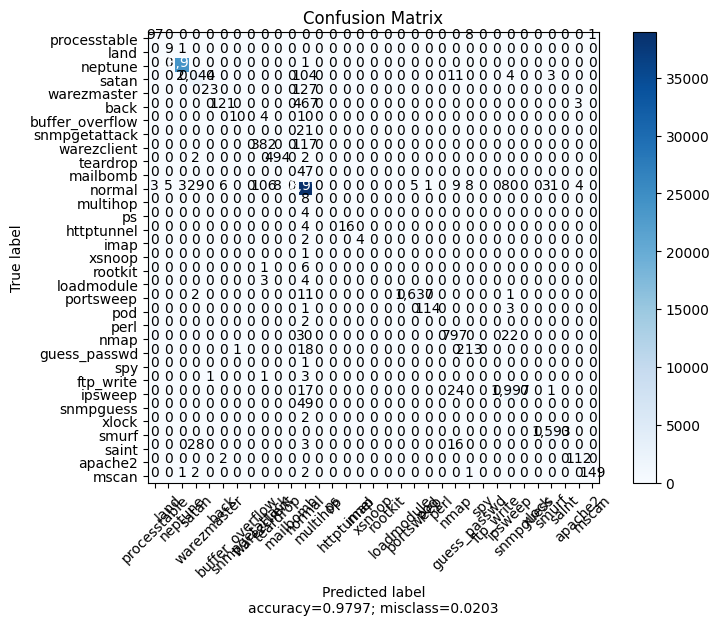

Validation score: 0.9795580333696926
train index: [     0      1      3 ... 148513 148514 148516]
test index: [     2      4      6 ... 148510 148511 148515]


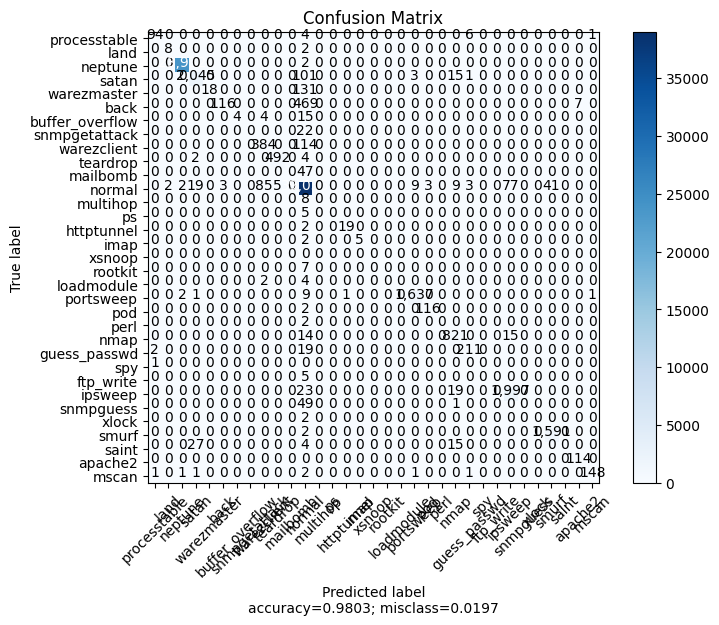

Validation score: 0.9802041530878828


In [33]:

for train_index, test_index in kfold.split(combined_data_X, y_train):
    train_X, test_X = combined_data_X.iloc[train_index], combined_data_X.iloc[test_index]
    train_y, test_y = y_train.iloc[train_index], y_train.iloc[test_index]
    
    print("train index:", train_index)
    print("test index:", test_index)
    
    x_columns_train = new_df_train.columns.drop('class')
    x_train_array = train_X[x_columns_train].values
    x_columns_test = new_df_train.columns.drop('class')
    x_test_array = test_X[x_columns_test].values
    
    Model = SequentialModel()   
    Model.fit(x_train_array, train_y)   
    
    pred = Model.predict(x_test_array)   
    
    score = metrics.accuracy_score(test_y, pred)   
    oos_svm_pred.append(score)
    y_true_numeric = [AttackEncodings.get(label, 0) for label in test_y]

    y_pred_numeric =  [AttackEncodings.get(label, 0) for label in pred] 
    cm = confusion_matrix(y_true_numeric, y_pred_numeric, labels = list(AttackEncodings.values()))
    plot_confusion_matrix(cm, normalize    = False, target_names = list(AttackEncodings.keys()),
                      title        = "Confusion Matrix")
    print("Validation score: {}".format(score))


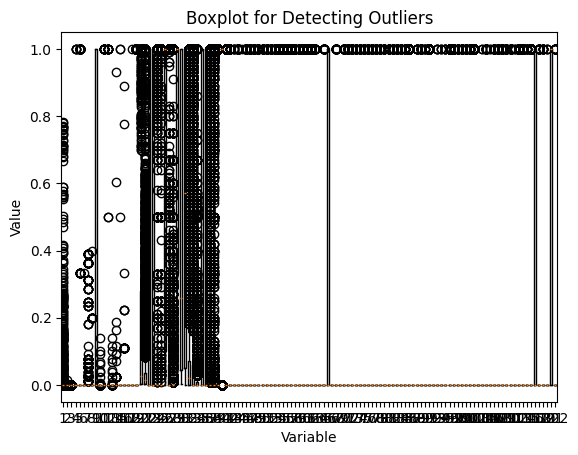

normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
neptune    -    neptune
normal    -    normal
normal    -    normal
mscan    -    mscan
normal    -    normal
normal    -    normal
normal    -    normal
neptune    -    neptune
satan    -    satan
neptune    -    neptune
normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
neptune    -    neptune
satan    -    satan
neptune    -    neptune
normal    -    normal
neptune    -    neptune
normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
normal    -    normal
neptune    -    neptune
neptune    -    neptune
normal    -    normal
neptune    -    neptune
neptune    -    neptune
teardrop    -    teardrop
normal    -    normal
normal    -    normal
neptune    -    neptune
neptune    -    neptune
normal    -    normal
neptune    -    neptune
normal    -    satan
ipsweep    -    ipsweep
normal 

In [52]:
target_class=[]
target_class=["DOS","Normal","Probe","R2L","U2R"]
train_X, test_X, train_y, test_y = train_test_split(combined_data_X, y_train, test_size=0.8, shuffle=True , random_state=42)

import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn.metrics import roc_curve, auc
 
combined_data = combined_data_X.sample(frac=1, random_state=42)
newDf = combined_data_X.sample(10000 , random_state=42)
plt.boxplot(newDf)

# Set labels and title
plt.xlabel('Variable')
plt.ylabel('Value')
plt.title('Boxplot for Detecting Outliers')

# Show the plot
plt.show()
Model = SequentialModel() 
Model.fit(train_X, train_y)


pred1 = Model.predict(test_X)
for prediction, actual in zip(pred1,test_y.values) :
      print(prediction ,"   -   ",actual)


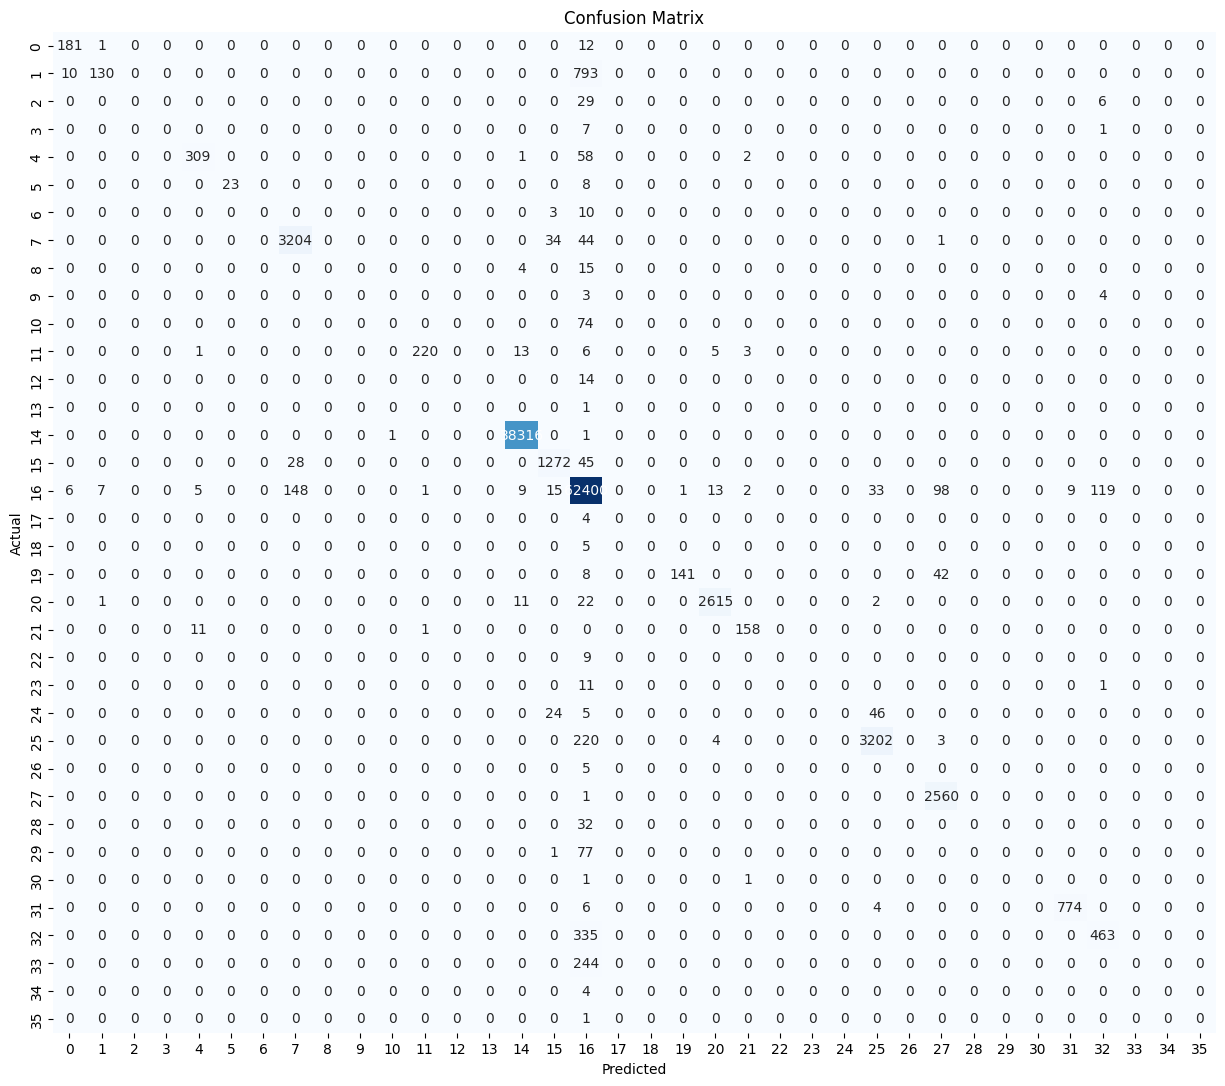

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Classification Report:
                 precision    recall  f1-score   support

        apache2       0.92      0.93      0.93       194
           back       0.94      0.14      0.24       933
buffer_overflow       0.00      0.00      0.00        35
      ftp_write       0.00      0.00      0.00         8
   guess_passwd       0.95      0.84      0.89       370
     httptunnel       1.00      0.74      0.85        31
           imap       0.00      0.00      0.00        13
        ipsweep       0.95      0.98      0.96      3283
           land       0.00      0.00      0.00        19
     loadmodule       0.00      0.00      0.00         7
       mailbomb       0.00      0.00      0.00        74
          mscan       0.99      0.89      0.94       248
       multihop       0.00      0.00      0.00        14
          named       0.00      0.00      0.00         1
        neptune       1.00      1.00      1.00     38318
           nmap       0.94      0.95      0.94      1345
       

/home/codespace/.local/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1497: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


ValueError: multiclass format is not supported

In [55]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Assuming you have y_actual and y_predicted data
# Example data
y_actual = test_y.values
y_predicted = pred1

# Confusion Matrix
cm = confusion_matrix(y_actual, y_predicted)
plt.figure(figsize=(15, 13))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
report = classification_report(y_actual, y_predicted)
print("Classification Report:")
print(report)
 




---



---



---



---

